  # Tablature Analysis of Music using Non-Standard Guitar Tunings

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# This two lines of code make your notebook aware of changes in
# your utils.py file without needing to restart the session each time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../scripts')

import analyse_data
import filter_by_tuning
import utils as u

## Analyse the Guitar Pro files in dataset

In [8]:
dataset_folder = "../dataset"
output_json = "analysis_results.json"
analyse_data.process_dataset_folder(dataset_folder, output_json)

In [10]:
# filtered_data_open_D = filter_by_tuning.load_analysis_file_by_tuning(output_json, "Open D")

# print("Filtered Guitars:")
# for guitar in filtered_data_open_D:
#   print(f"Title: {guitar['title']}, Artist: {guitar['artist']}, Track: {guitar['track_name']}")
#   print(f"Tuning: {guitar['tuning']} ({guitar['tuning_label']})")
#   print(f"String-Fret Frequency: {guitar['string_fret_frequency']}")
#   print("-" * 50)

## Plot string frequencies per fret for the different tunings

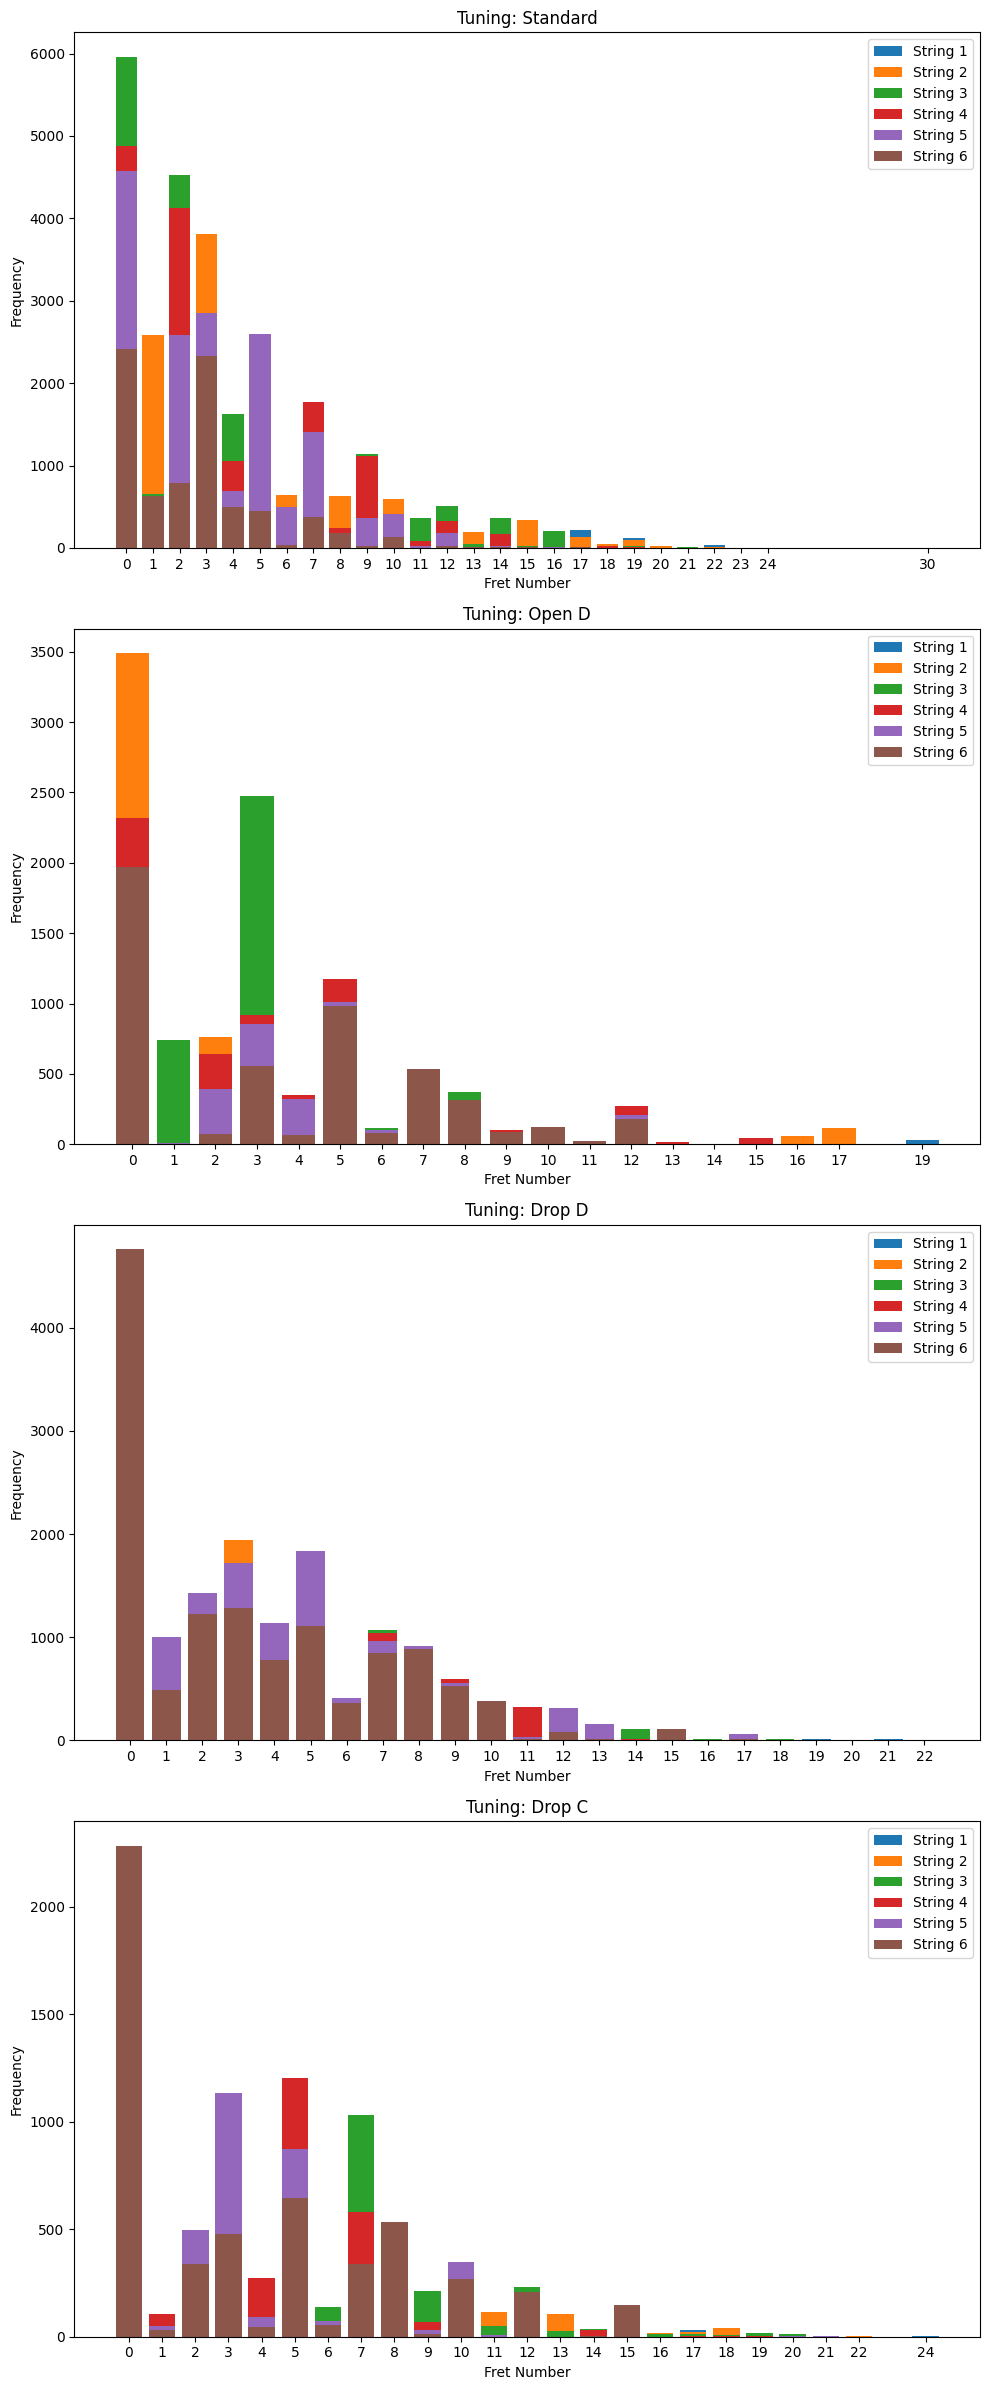

In [12]:
def aggregate_string_fret_frequency(data):
    """Aggregate string-fret frequency for a list of tracks."""
    aggregated = {}
    for track in data:
        for string, frets in track.get("string_fret_frequency", {}).items():
            if string not in aggregated:
                aggregated[string] = {}
            for fret, count in frets.items():
                aggregated[string][int(fret)] = aggregated[string].get(int(fret), 0) + count  # Ensure fret is an integer
    return aggregated

def plot_tuning_comparison(data, tuning_labels):
    """Plot a comparison of string-fret frequencies for multiple tunings."""
    aggregated_data = {}
    
    # Aggregate data for each tuning
    for tuning_label in tuning_labels:
        filtered_data = filter_by_tuning.filter_guitars_by_tuning_label(data, tuning_label)
        aggregated_data[tuning_label] = aggregate_string_fret_frequency(filtered_data)
    
    # Plot the data
    fig, axes = plt.subplots(len(tuning_labels), 1, figsize=(10, 6 * len(tuning_labels)))
    if len(tuning_labels) == 1:
        axes = [axes]  # Ensure axes is iterable for a single plot
    
    for ax, tuning_label in zip(axes, tuning_labels):
        aggregated = aggregated_data[tuning_label]
        all_fret_numbers = set()  # Collect all fret numbers for consistent x-axis ticks
        for string, frets in aggregated.items():
            # Sort fret numbers and corresponding counts
            sorted_frets = sorted(frets.items())  # Sort by fret number (as integers)
            fret_numbers, fret_counts = zip(*sorted_frets)  # Unzip into two lists
            
            all_fret_numbers.update(fret_numbers)  # Add fret numbers to the set
            ax.bar(fret_numbers, fret_counts, label=f"String {string}")
        
        # Set x-axis ticks to show all fret numbers
        ax.set_xticks(sorted(all_fret_numbers))  # Ensure ticks are integers and sorted
        ax.set_title(f"Tuning: {tuning_label}")
        ax.set_xlabel("Fret Number")
        ax.set_ylabel("Frequency")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Path to the guitar analysis JSON file
filepath = "analysis_results.json"

# Load the data
data = u.load_guitar_analysis(filepath)

# Specify the tunings to compare
tunings_to_compare = ["Standard", "Open D", "Drop D", "Drop C"]

# Plot the comparison
plot_tuning_comparison(data, tunings_to_compare)


### normalize the data by the number of notes in the track to get the proportion

In [10]:
import json

# Load the JSON data
with open(output_json, 'r') as file:
    data = json.load(file)

# Normalize frequencies
for track in data:
    for track_data in track.get("tracks", []):
        string_fret_frequency = track_data.get("string_fret_frequency", {})
        total_notes = sum(
            sum(frequencies.values()) for frequencies in string_fret_frequency.values()
        )
        
        if total_notes > 0:  # Avoid division by zero
            for string, frequencies in string_fret_frequency.items():
                for fret, count in frequencies.items():
                    frequencies[fret] = count / total_notes  # Normalize

# Save the normalized data back to a file
with open('normalized_analysis_results.json', 'w') as file:
    json.dump(data, file, indent=4)

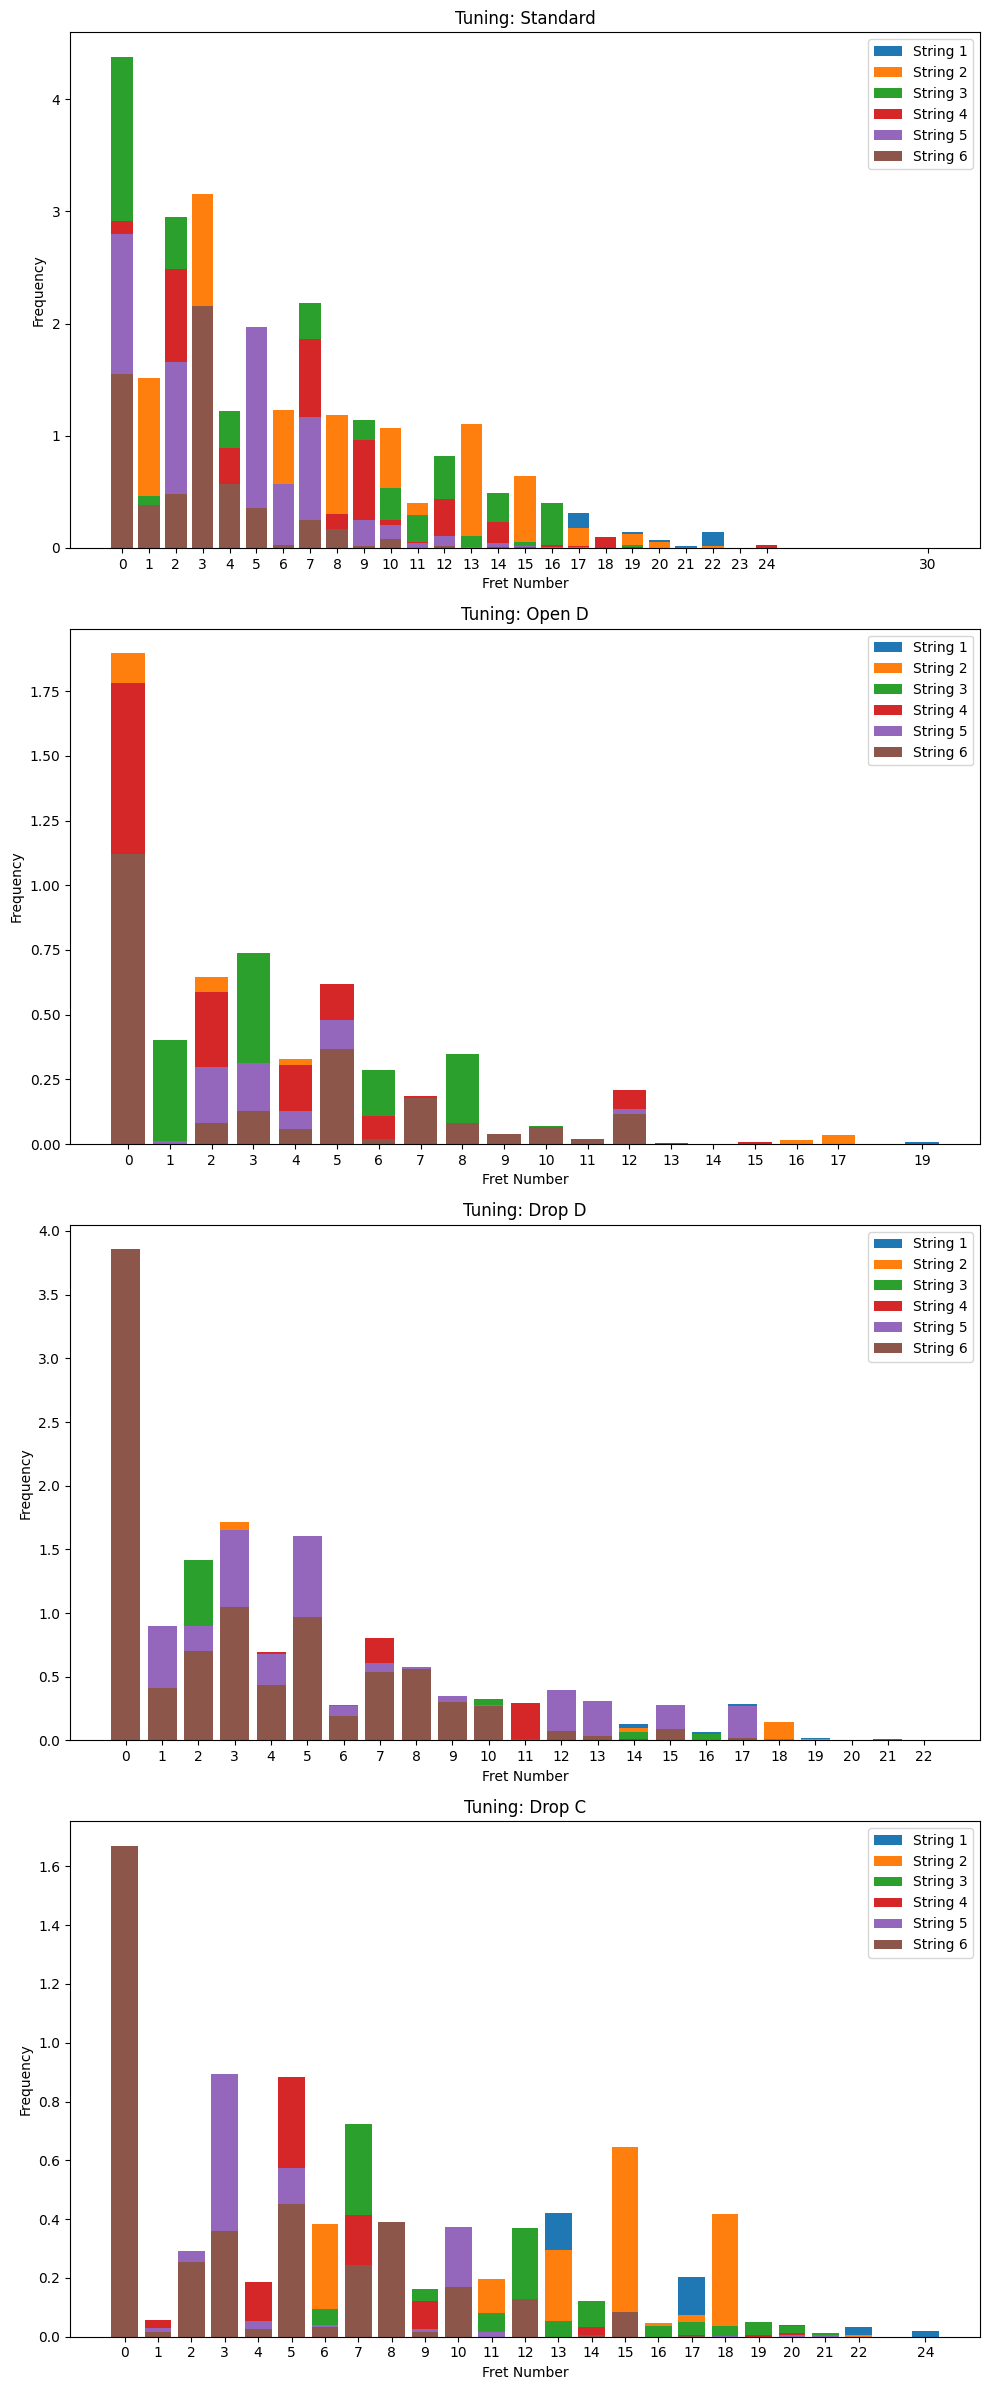

In [13]:
def aggregate_string_fret_frequency(data):
    """Aggregate and normalize string-fret frequency for a list of tracks."""
    aggregated = {}
    for track in data:
        total_notes = sum(
            count for frets in track.get("string_fret_frequency", {}).values() for count in frets.values()
        )  # Calculate total number of notes in the track
        
        for string, frets in track.get("string_fret_frequency", {}).items():
            if string not in aggregated:
                aggregated[string] = {}
            for fret, count in frets.items():
                # Normalize by total number of notes
                normalized_count = count / total_notes if total_notes > 0 else 0
                aggregated[string][int(fret)] = aggregated[string].get(int(fret), 0) + normalized_count
    return aggregated



# def plot_tuning_comparison(data, tuning_labels):
#     """Plot a comparison of string-fret proportions for multiple tunings."""
#     aggregated_data = {}
    
#     # Aggregate data for each tuning
#     for tuning_label in tuning_labels:
#         filtered_data = filter_by_tuning.filter_guitars_by_tuning_label(data, tuning_label)
#         aggregated_data[tuning_label] = aggregate_string_fret_frequency(filtered_data)
    
#     # Plot the data
#     fig, axes = plt.subplots(len(tuning_labels), 1, figsize=(10, 6 * len(tuning_labels)))
#     if len(tuning_labels) == 1:
#         axes = [axes]  # Ensure axes is iterable for a single plot
    
#     for ax, tuning_label in zip(axes, tuning_labels):
#         aggregated = aggregated_data[tuning_label]
#         all_fret_numbers = set()  # Collect all fret numbers for consistent x-axis ticks
        
#         # Prepare data for plotting
#         for string, frets in aggregated.items():
#             fret_numbers = sorted(frets.keys())
#             proportions = [frets[fret] for fret in fret_numbers]
#             all_fret_numbers.update(fret_numbers)
            
#             # Plot proportions for each string
#             ax.plot(fret_numbers, proportions, label=f"String {string}")
        
#         ax.set_title(f"Tuning: {tuning_label}")
#         ax.set_xlabel("Fret Number")
#         ax.set_ylabel("Proportion of Notes Played")  # Updated y-axis label
#         ax.legend()
#         ax.grid(True)
    
#     plt.tight_layout()
#     plt.show()

def main():
    # Path to the guitar analysis JSON file
    filepath = "normalized_analysis_results.json"
    
    # Load the data
    data = u.load_guitar_analysis(filepath)
    
    # Specify the tunings to compare
    tunings_to_compare = ["Standard", "Open D", "Drop D", "Drop C"]
    
    # Plot the comparison
    plot_tuning_comparison(data, tunings_to_compare)

main()